In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy as sp
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

In [2]:
SEED = 1234567890
np.random.seed(SEED)

#### Code 8.1

In [3]:
num_weeks = int(1e5)
positions = np.empty(num_weeks, dtype=np.int64)
current = 9

for i in range(num_weeks):
    # record current position
    positions[i] = current

    # flip coin to generate proposal
    proposal = current + np.random.choice([-1, 1])
    # now make sure he loops around the archipelago
    proposal %= 10
    
    #move?
    prob_move = (proposal + 1) / (current + 1)
    current = proposal if np.random.uniform() < prob_move else current

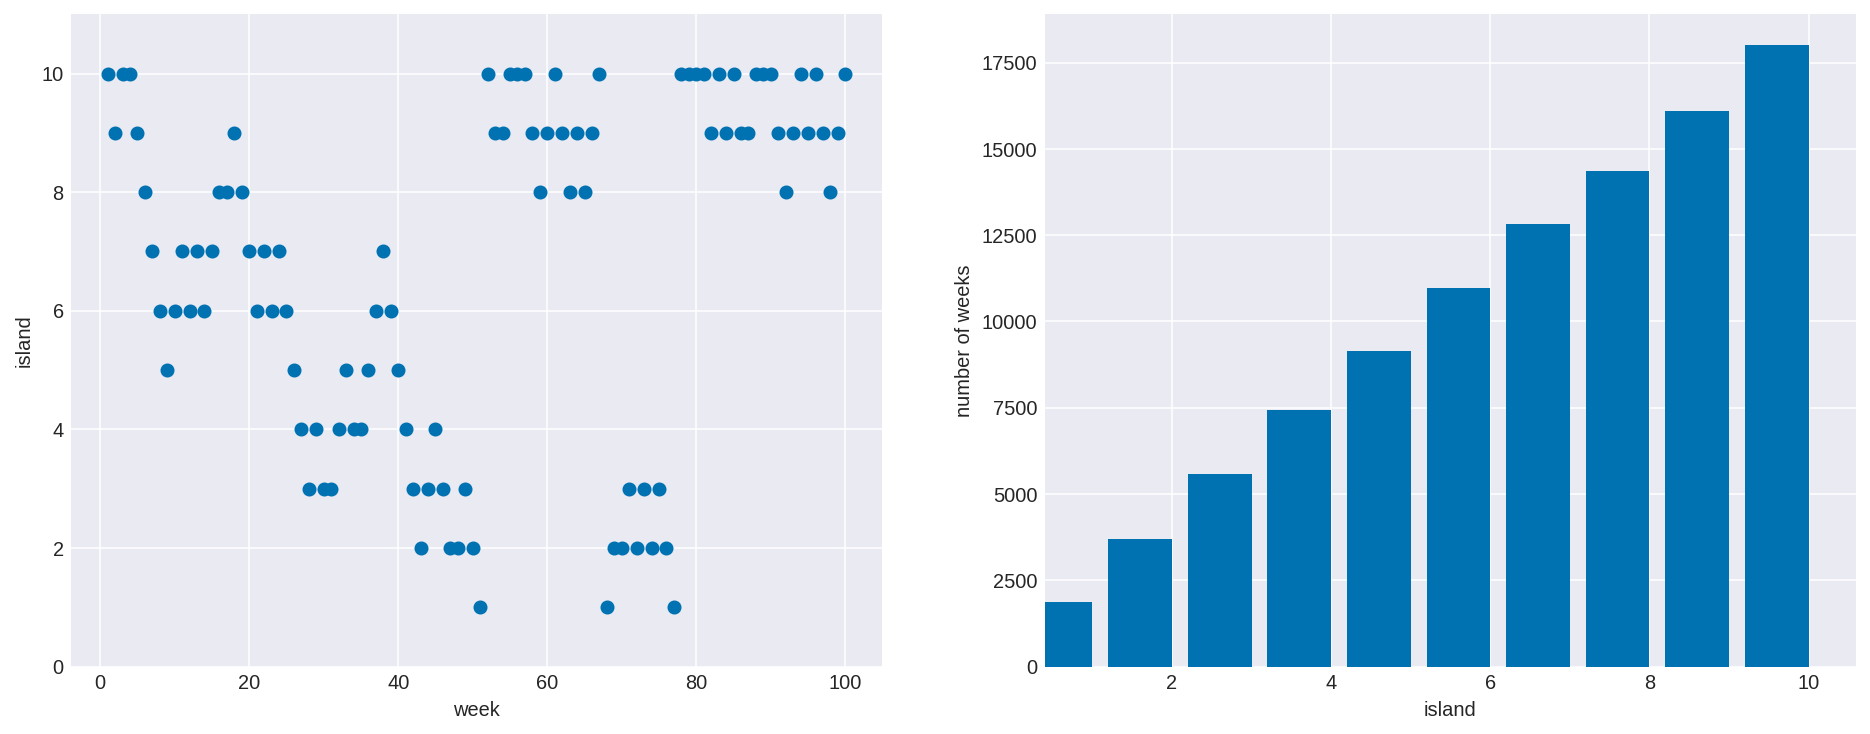

In [4]:
_, (week_ax, island_ax) = plt.subplots(ncols=2, figsize=(16, 6))

week_ax.scatter(np.arange(100) + 1, positions[:100] + 1);

week_ax.set_xlabel('week');
week_ax.set_ylim(0, 11);
week_ax.set_ylabel('island');

island_ax.bar(np.arange(10) + 0.6, np.bincount(positions));

island_ax.set_xlim(0.4, 10.6);
island_ax.set_xlabel('island');
island_ax.set_ylabel('number of weeks');

#### Code 8.2

In [5]:
rugged_df = (pd.read_csv('Data/rugged.csv', sep=';')
               .assign(log_gdp=lambda df: np.log(df.rgdppc_2000))
               .dropna(subset=['log_gdp']))

#### Code 8.3

In [6]:
with pm.Model() as m8_1_map:
    a = pm.Normal('a', 0., 100.)
    bR = pm.Normal('bR', 0., 10.)
    bA = pm.Normal('bA', 0., 10.)
    bAR = pm.Normal('bAR', 0., 10.)
    mu = a \
            + bR * rugged_df.rugged \
            + bA * rugged_df.cont_africa \
            + bAR * rugged_df.rugged * rugged_df.cont_africa
    
    sigma = pm.Uniform('sigma', 0., 10.)
    
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=rugged_df.log_gdp)

In [7]:
with m8_1_map:
    map_8_1 = pm.find_MAP()

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -246.89, ||grad|| = 0.297: 100%|██████████| 36/36 [00:00<00:00, 1422.33it/s]           


In [8]:
map_8_1

{'a': array(9.22278924),
 'bR': array(-0.20265346),
 'bA': array(-1.94694634),
 'bAR': array(0.39290435),
 'sigma_interval__': array(-2.27437128),
 'sigma': array(0.9326788)}

#### Code 8.5

In [9]:
with pm.Model() as m8_1:
    a = pm.Normal('a', 0., 100.)
    bR = pm.Normal('bR', 0., 10.)
    bA = pm.Normal('bA', 0., 10.)
    bAR = pm.Normal('bAR', 0., 10.)
    mu = a \
            + bR * rugged_df.rugged \
            + bA * rugged_df.cont_africa \
            + bAR * rugged_df.rugged * rugged_df.cont_africa
    
    sigma = pm.HalfCauchy('sigma', 2.)
    
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=rugged_df.log_gdp)

In [10]:
with  m8_1:
    trace_8_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 749.30draws/s] 


In [11]:
pm.summary(trace_8_1, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.23,0.13,0.00,9.01,9.43,889.14,1.0
bR,-0.21,0.07,0.00,-0.32,-0.09,824.84,1.0
bA,-1.95,0.22,0.01,-2.28,-1.58,879.16,1.0
bAR,0.39,0.13,0.00,0.20,0.60,978.97,1.0
sigma,0.95,0.05,0.00,0.86,1.03,1904.31,1.0


#### Code 8.7

In [12]:
with m8_1:
    trace_8_1_4_chains = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bAR, bA, bR, a]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 685.80draws/s]


In [13]:
pm.summary(trace_8_1_4_chains, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.22,0.14,0.00,9.02,9.46,986.66,1.0
bR,-0.20,0.08,0.00,-0.34,-0.09,933.71,1.0
bA,-1.94,0.23,0.01,-2.29,-1.57,1071.95,1.0
bAR,0.39,0.13,0.00,0.18,0.59,1059.60,1.0
sigma,0.95,0.05,0.00,0.86,1.04,1909.03,1.0


#### Code 8.8

In [14]:
trace_8_1_df = pm.trace_to_dataframe(trace_8_1)

In [15]:
trace_8_1_df.head()

,a,bR,bA,bAR,sigma
0,9.136381,-0.162511,-2.179138,0.601650,0.905326
1,9.224959,-0.198604,-1.846557,0.212187,0.970203
2,9.113374,-0.116848,-1.792168,0.119976,0.954766
3,8.952142,-0.130088,-1.760261,0.395429,0.892187
4,9.330335,-0.211126,-2.068826,0.321654,0.892928


#### Code 8.9 and 8.10

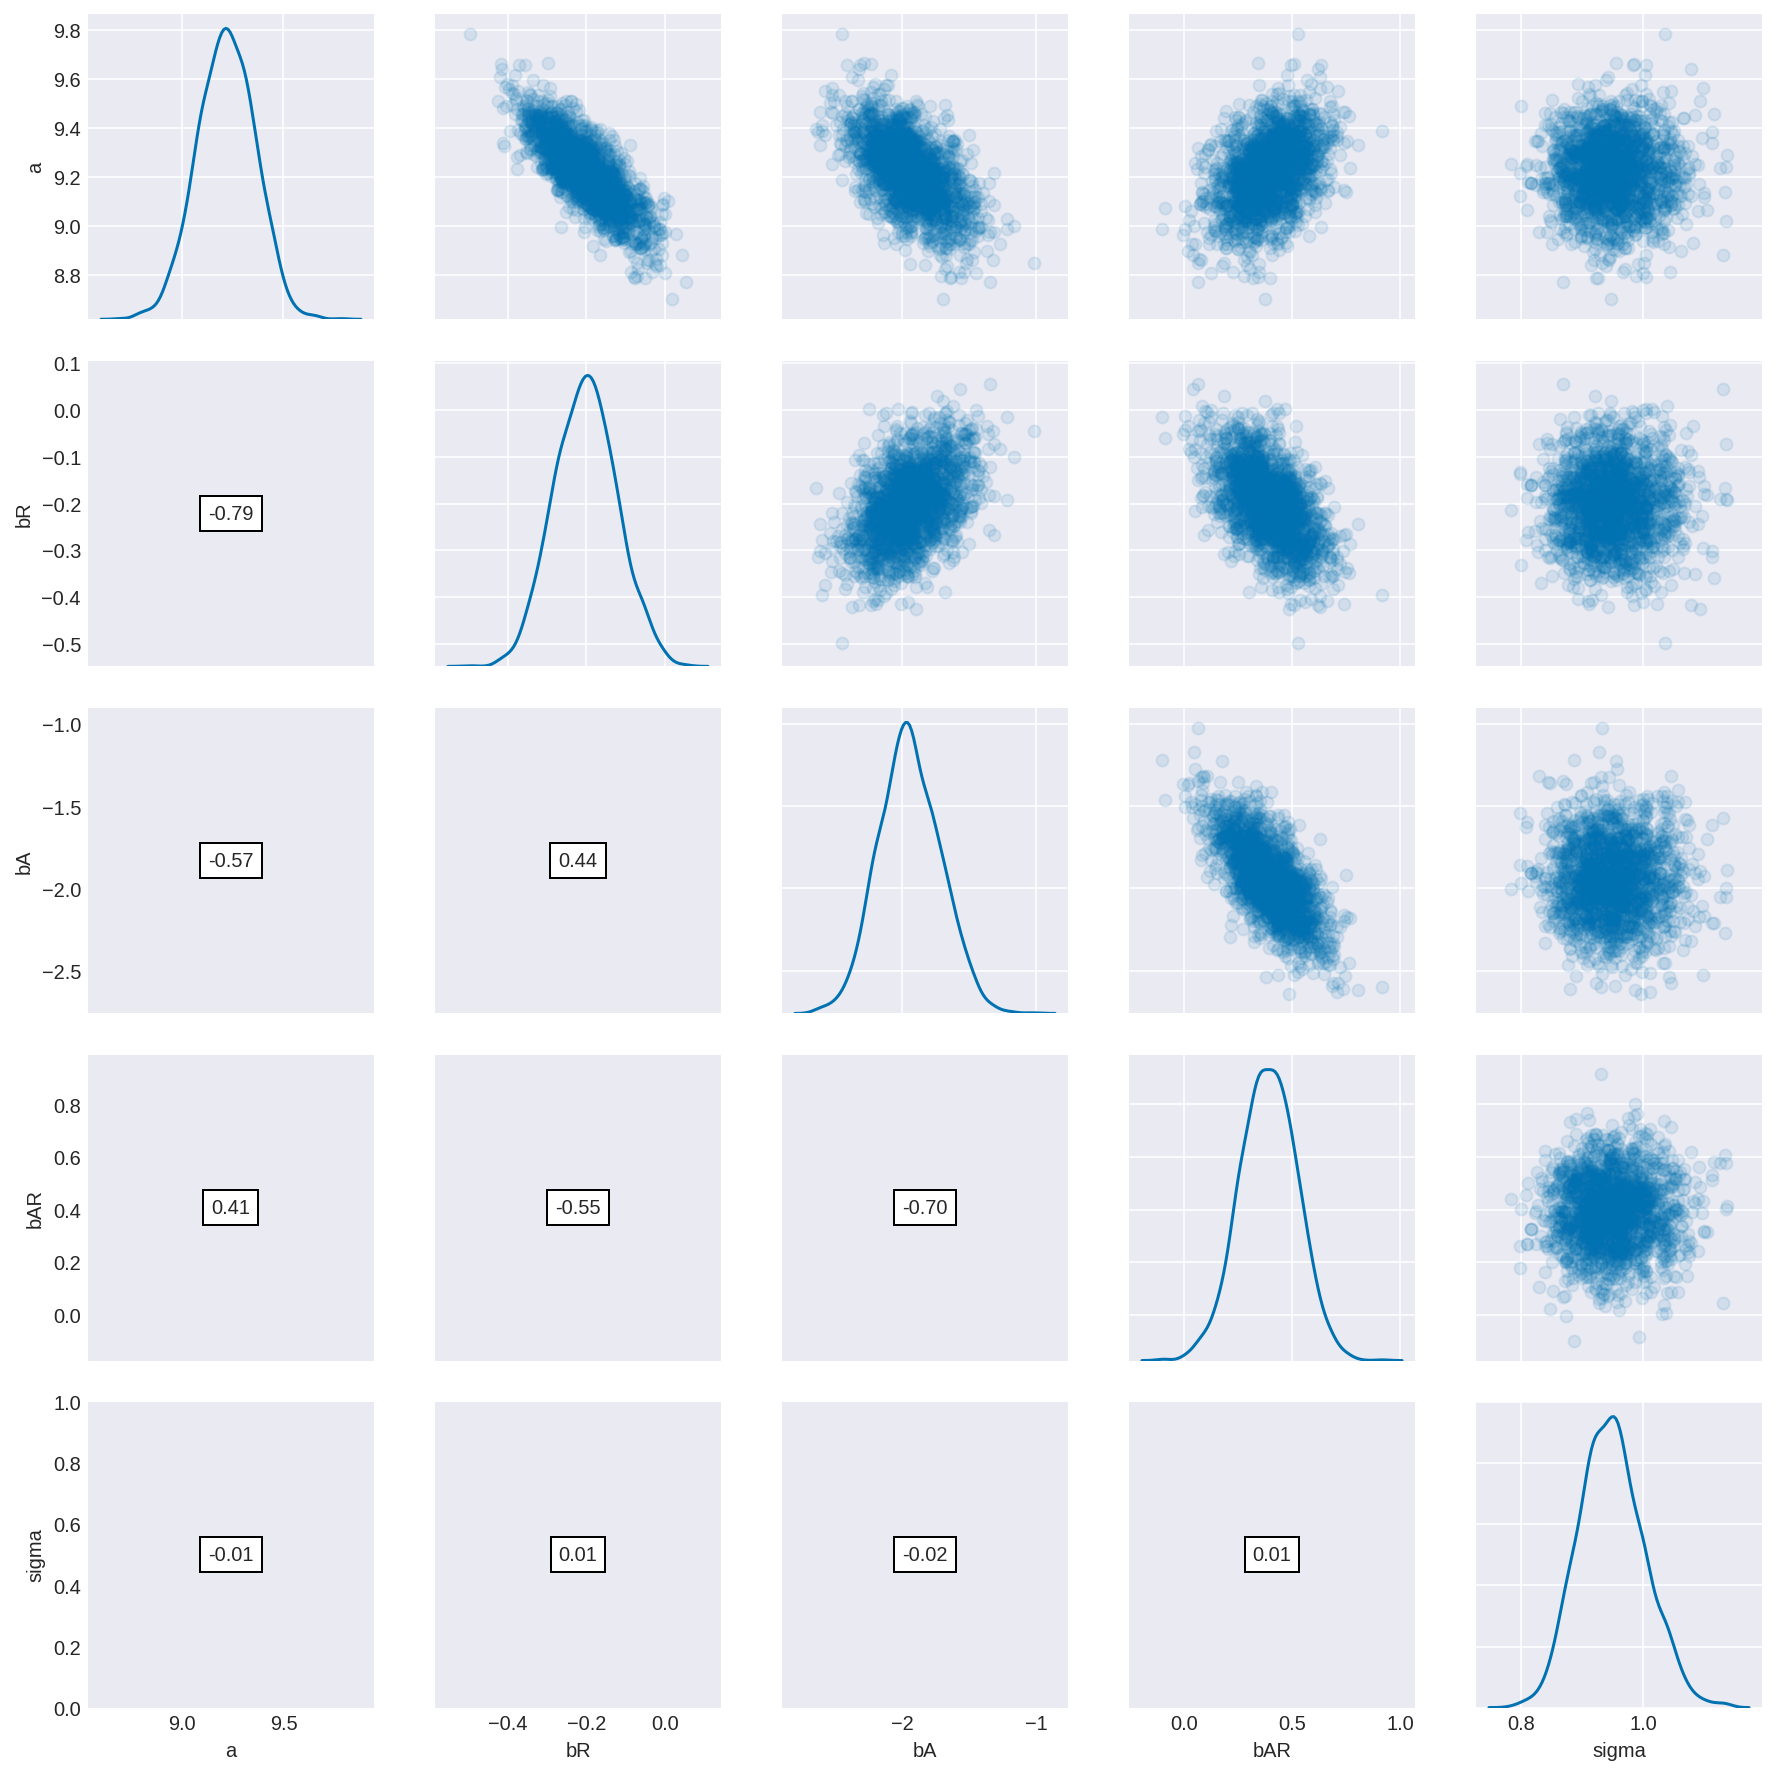

In [16]:
def plot_corr(x, y, **kwargs):
    corrcoeff = np.corrcoef(x, y)[0, 1]
    
    artist = AnchoredText('{:.2f}'.format(corrcoeff), loc=10)
    plt.gca().add_artist(artist)
    plt.grid(b=False)

trace_8_1_df = pm.trace_to_dataframe(trace_8_1_4_chains)
grid = (sns.PairGrid(trace_8_1_df,
                     x_vars=['a', 'bR', 'bA', 'bAR', 'sigma'],
                     y_vars=['a', 'bR', 'bA', 'bAR', 'sigma'],
                     diag_sharey=False)
           .map_diag(sns.kdeplot)
           .map_upper(plt.scatter, alpha=0.1)
           .map_lower(plot_corr))

#### Code 8.11

In [17]:
m8_1.logp({
    varname: trace_8_1[varname].mean()
        for varname in trace_8_1.varnames})

array(-246.02912848)

The computation of DIC has been deprecated and is no longer available in PyMC3

In [18]:
pm.waic(trace_8_1, model=m8_1)

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


WAIC_r(WAIC=468.98305534228575, WAIC_se=14.819521192935657, p_WAIC=4.941392790061401, var_warn=1)

#### Code 8.12

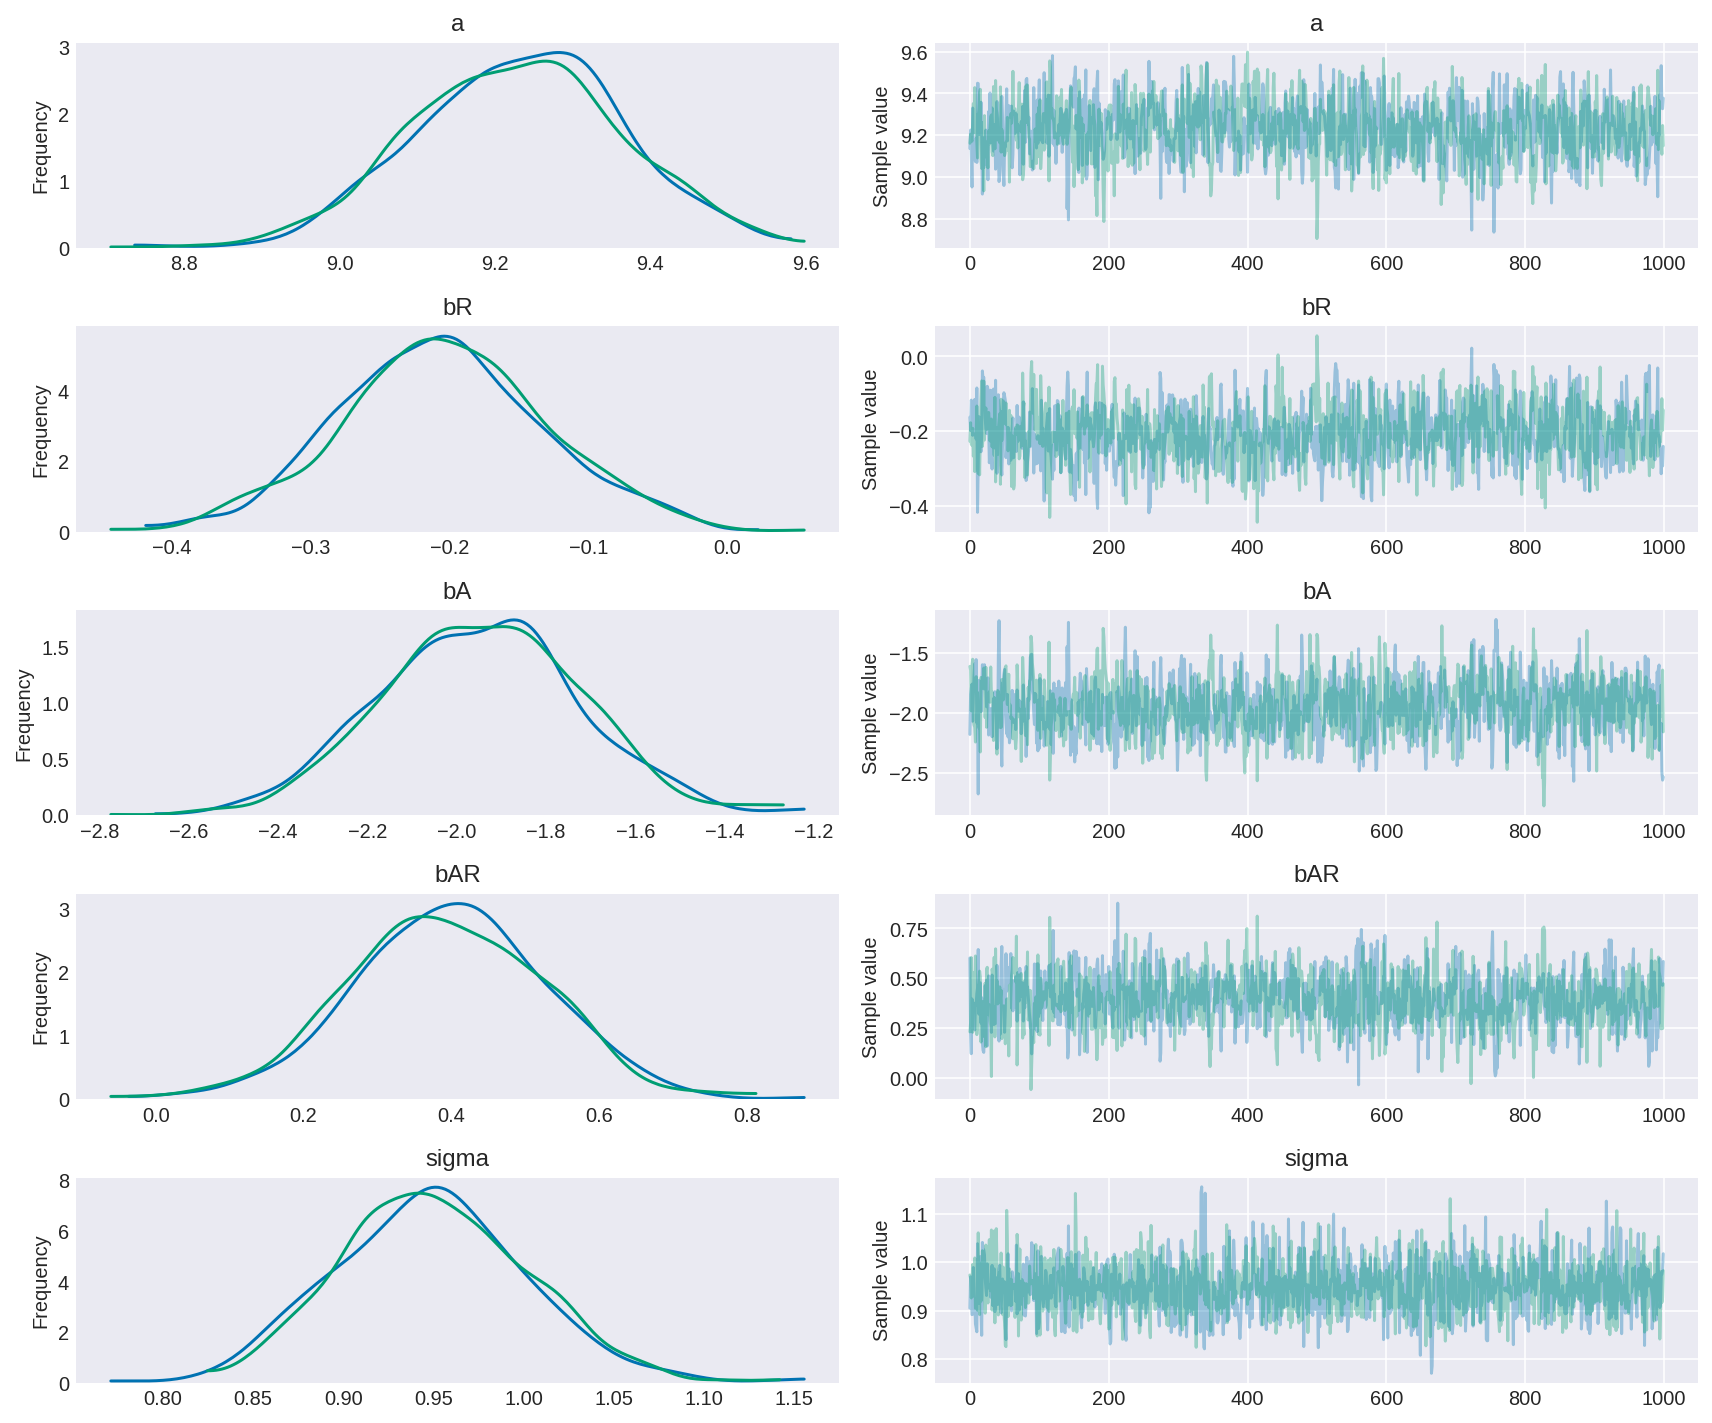

In [19]:
pm.traceplot(trace_8_1);

#### Code 8.13

In [20]:
y = np.array([-1., 1.])

with pm.Model() as m8_2:
    alpha = pm.Flat('alpha')
    sigma = pm.Bound(pm.Flat, lower=0.)('sigma')
    
    y_obs = pm.Normal('y_obs', alpha, sigma, observed=y)

In [21]:
with m8_2:
    trace_8_2 = pm.sample(draws=2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:26<00:00, 306.16draws/s] 
There were 129 divergences after tuning. Increase `target_accept` or reparameterize.
There were 77 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


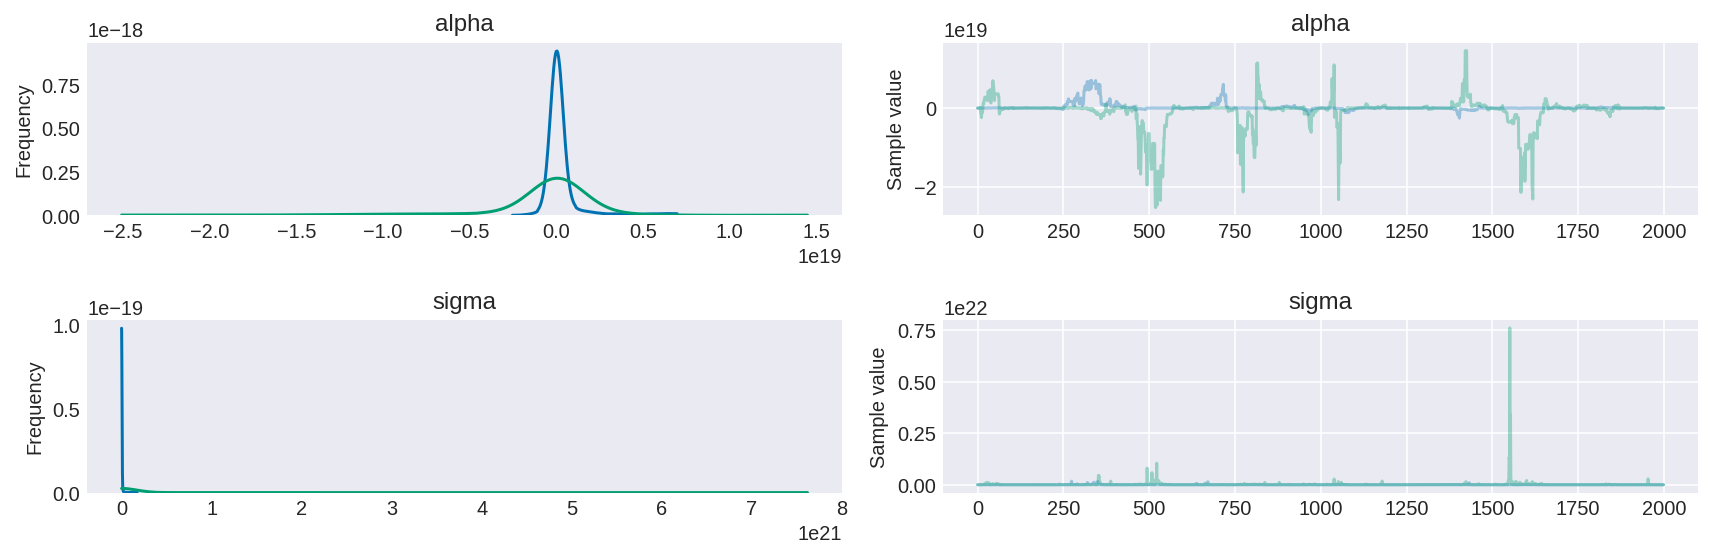

In [22]:
pm.traceplot(trace_8_2);

In [23]:
pm.effective_n(trace_8_2)

{'alpha': 63.263458522400384, 'sigma': 917.5833922818342}

#### Code 8.14

In [24]:
pm.summary(trace_8_2, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,-3.750367e+17,2.930271e+18,2.312097e+17,-1.977800e+18,1.894043e+18,63.26,1.04
sigma,9.555344e+18,1.396730e+20,4.145108e+18,6.078430e+14,7.695503e+18,917.58,1.00


#### Code 8.15

In [25]:
with pm.Model() as m8_3:
    alpha = pm.Normal('alpha', 1., 10.)
    sigma = pm.HalfCauchy('sigma', 1.)
    
    y_obs = pm.Normal('y_obs', alpha, sigma, observed=y)

In [26]:
with m8_3:
    trace_8_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, alpha]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1431.51draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5916653548094629, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [27]:
pm.summary(trace_8_3, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,0.03,1.76,0.08,-2.29,2.54,527.89,1.0
sigma,2.09,2.91,0.14,0.45,3.50,385.47,1.0


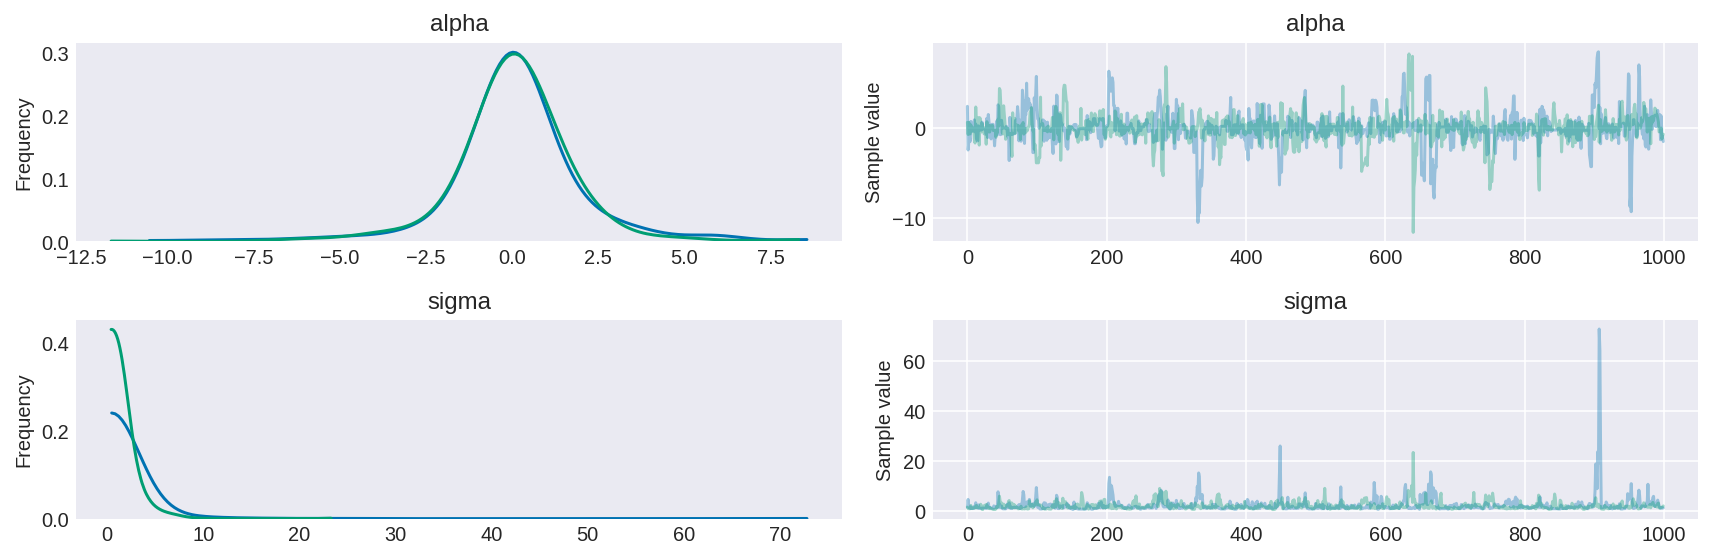

In [28]:
pm.traceplot(trace_8_3);

#### Code 8.16

In [29]:
y = sp.stats.cauchy.rvs(0., 5., size=int(1e4))
mu = y.cumsum() / (1 + np.arange(int(1e4)))

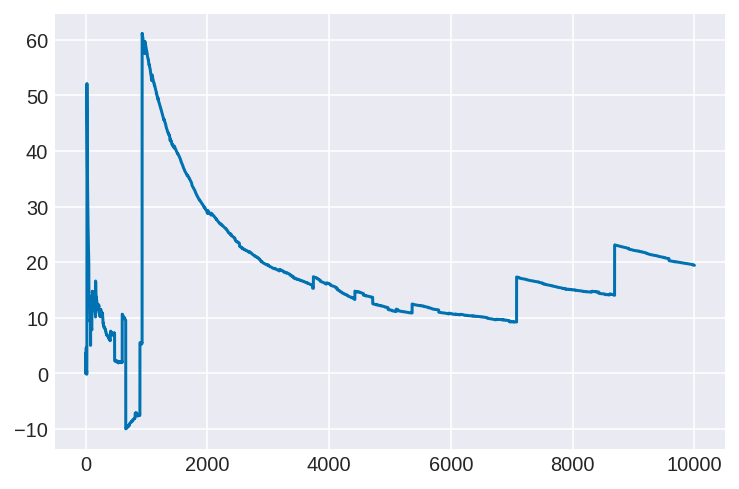

In [30]:
plt.plot(mu);

#### Code 8.17

To construct a non-identifiable model, we first simulate 100 observations from a Gaussian distribution with mean zero and standard deviation 1.

In [31]:
y = np.random.normal(0., 1., size=100)

#### Code 8.18

The linear model contains two parameters, α 1 and α 2 , which cannot be identified. Only their sum can be identified, and it should be about zero, after estimation.

In [32]:
with pm.Model() as m8_4:
    a1 = pm.Flat('a1')
    a2 = pm.Flat('a2')
    sigma = pm.HalfCauchy('sigma', 1.)
    
    y_obs = pm.Normal('y_obs', a1 + a2, sigma, observed=y)

In [33]:
with m8_4:
    trace_8_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a2, a1]
Sampling 2 chains: 100%|██████████| 4000/4000 [04:30<00:00,  5.66draws/s] 
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 515 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.04902599127143516, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [34]:
pm.summary(trace_8_4, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a1,564.20,1431.84,143.05,-822.36,2366.32,1.06,5.52
a2,-564.25,1431.85,143.05,-2366.29,822.35,1.06,5.52
sigma,0.93,0.06,0.01,0.89,1.03,1.75,1.70


Those estimates look suspicious, and the n_eff and Rhat values are terrible. The means for a1 and a2 are almost exactly the same distance from zero, but on opposite sides. And the standard deviations of the chains are massive. This is of course a result of the fact that we cannot simultaneously estimate a1 and a2 , but only their sum.

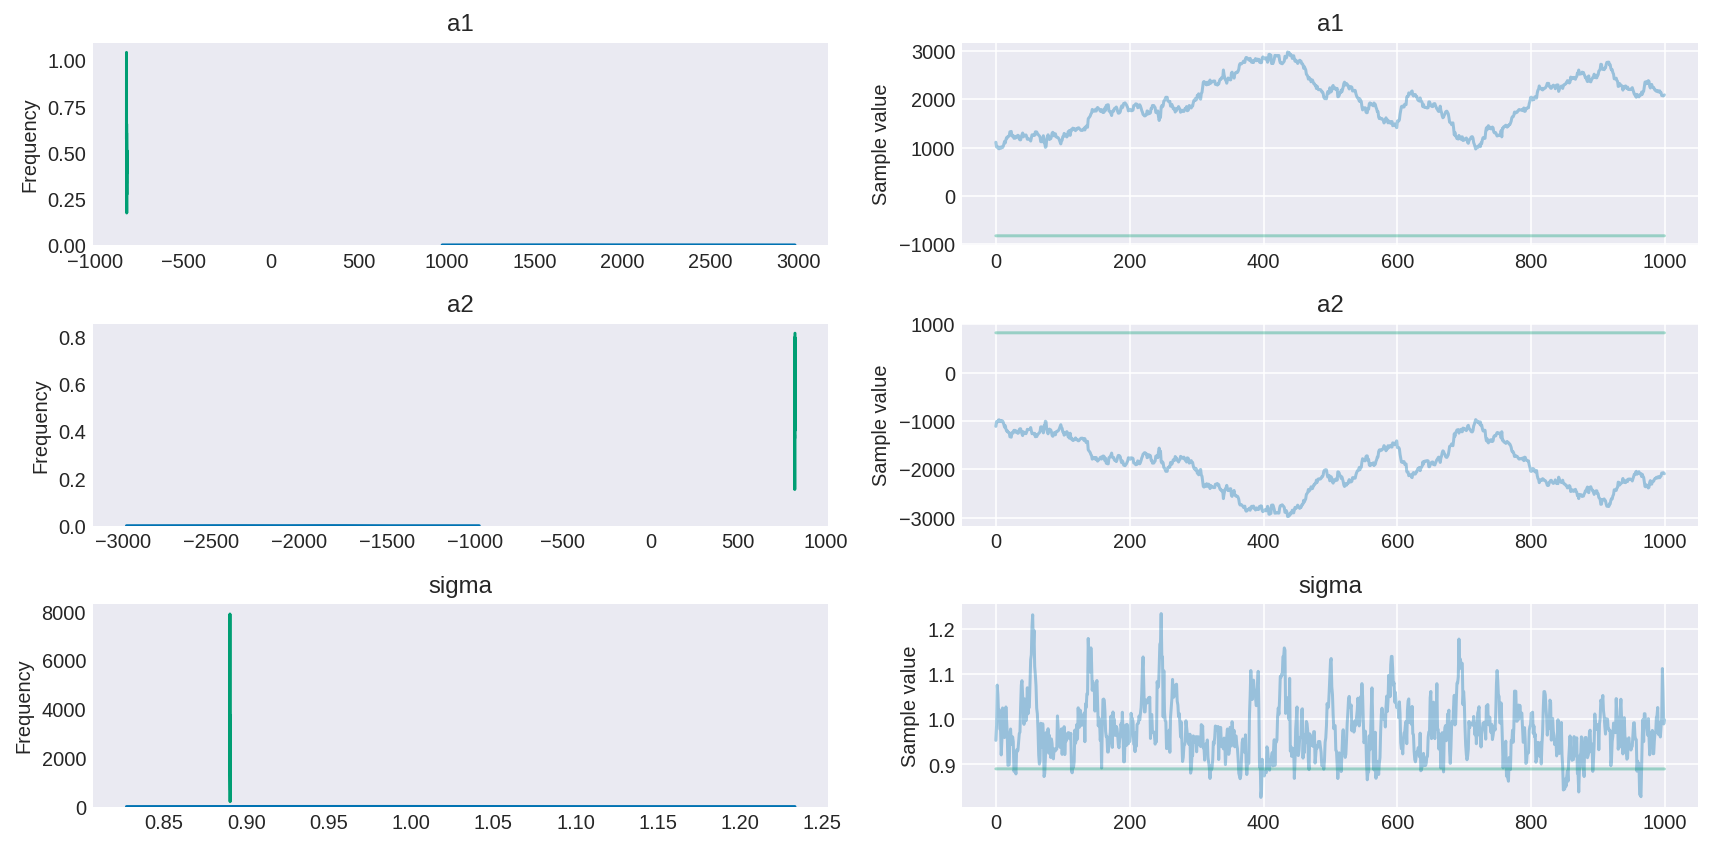

In [35]:
pm.traceplot(trace_8_4);

Looking at the trace plot reveals more. The left column in the plot above ashows two Markov chains from the model above. These chains do not look like they are stationary, nor do they seem to be mixing very well. Indeed, when you see a pattern like this, it is reason to worry. Don’t use these samples.

#### Code 8.19

Again, weak priors can rescue us

In [36]:
with pm.Model() as m8_5:
    a1 = pm.Normal('a1', 0., 10.)
    a2 = pm.Normal('a2', 0., 10.)
    sigma = pm.HalfCauchy('sigma', 1.)
    
    y_obs = pm.Normal('y_obs', a1 + a2, sigma, observed=y)

In [37]:
with m8_5:
    trace_8_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a2, a1]
Sampling 2 chains: 100%|██████████| 4000/4000 [01:26<00:00, 25.93draws/s]


In [38]:
pm.summary(trace_8_5, alpha=.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a1,-0.06,6.93,0.29,-11.49,10.62,564.01,1.0
a2,0.01,6.94,0.29,-10.75,11.22,564.64,1.0
sigma,0.97,0.07,0.00,0.85,1.07,780.46,1.0


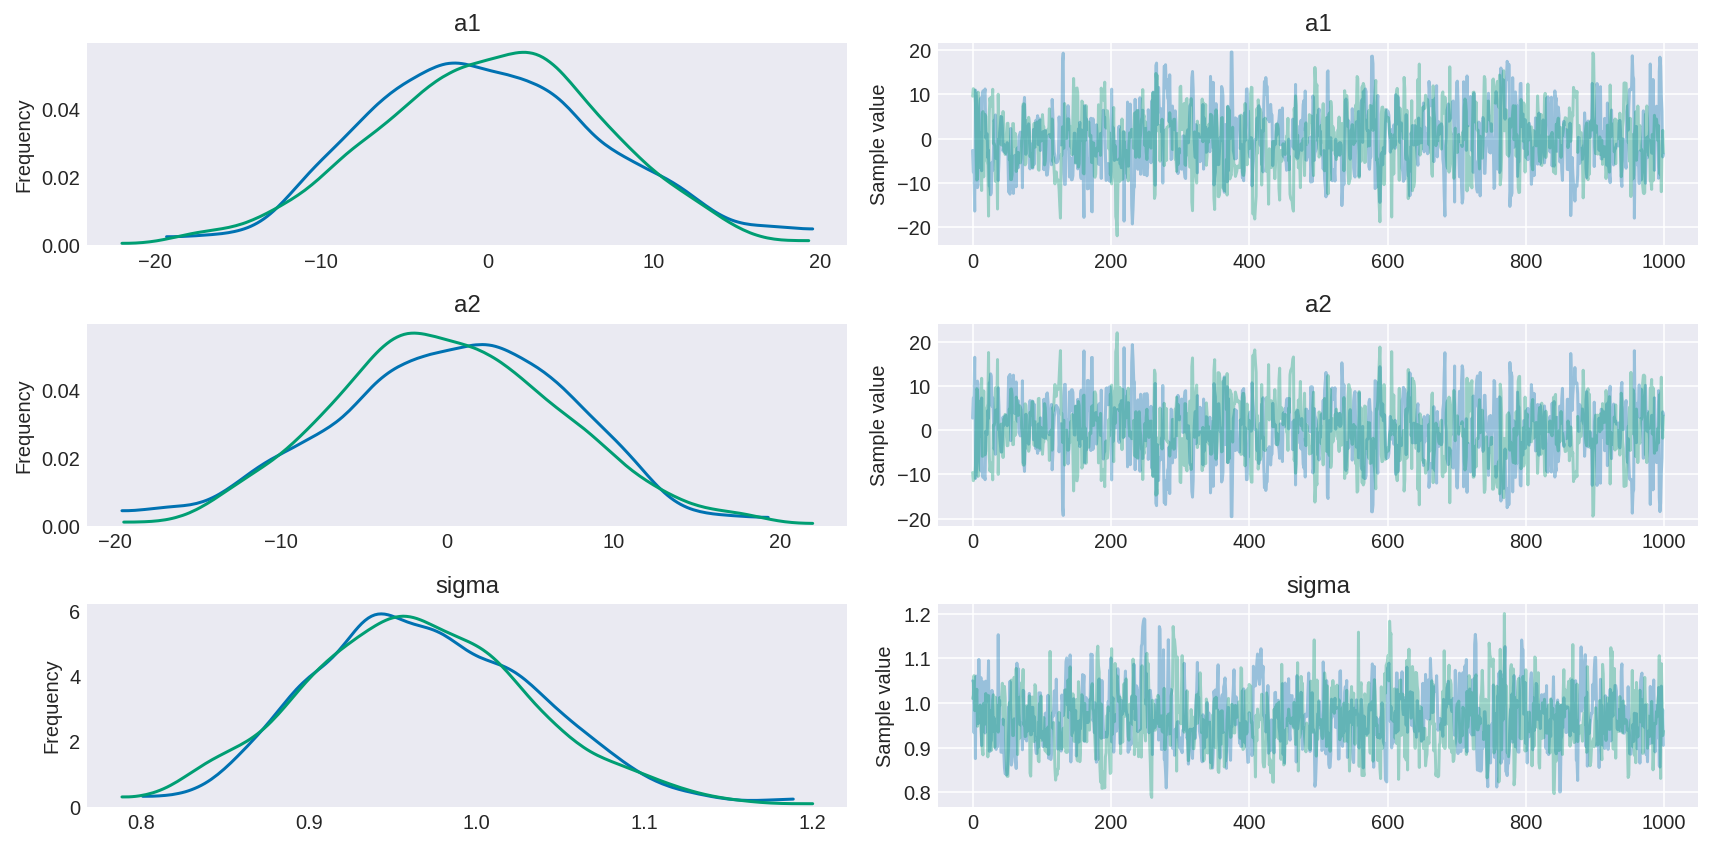

In [39]:
pm.traceplot(trace_8_5);

In [40]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nPandas %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, pd.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.7.2
IPython 7.6.1
PyMC3 3.6
NumPy 1.16.0
Pandas 0.23.4
SciPy 1.2.0
Matplotlib 3.0.2



/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  
